In [1]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle 
import numpy as np
import functools
import sys 
ρcrit0 = 2.77533742639e+11 #h^2 Msol / Mpc^3
cosmo_params = pickle.load(open('data/cosmo_params.pkl', 'rb'))

In [2]:
import torch
import gpytorch


In [3]:
def log_likelihood(param_values):
    lp = log_prior(param_values)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_prob(param_values)

In [4]:
param_names = [ 'd1','e0' ,'e1','f0', 'g0','g1']

FIXED = {
         'f1':0.12,
         'd0':2.4,
        }

In [49]:
from os.path import exists
params = {}


ndim = len(param_names)
for box in cosmo_params:
    if('Box5_1400' in box): #something weird going on
        continue
    #check if there is a fit for this box by checking if the corresponding figure exsits
    fig_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_fit_%.2f.pdf'%(box, 1.0)
    if(not exists(fig_fname)):
        print('Skipping %s'%(box))
        continue
    sampler = None
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_MCMC_sampler.pkl"%(box), "rb") as f:
        sampler = pickle.load(f)
    samples = sampler.chain[:, 4000:, :].reshape((-1, ndim))
    final_param_vals = np.percentile(samples,  50,axis=0)
    params[box] = dict(zip(param_names, final_param_vals))

Skipping Box12_1400
Skipping Box15_1400
Skipping Box21_1400
Skipping Box22_1400
Skipping Box35_1400
Skipping Box36_1400
Skipping Box47_1400
Skipping Box49_1400
Skipping Box52_1400
Skipping Box54_1400
Skipping Box63_1400
Skipping Box70_1400
Skipping Box82_1400
Skipping Box85_1400
Skipping Box95_1400


In [50]:
def train_test_split(length, split=0.7):
    indices = np.random.permutation(length)
    split_len = int(length*split)
    return indices[:split_len], indices[split_len:]

In [51]:
X, Y = [], []
for box in params:
    X += [list(cosmo_params[box].values())]
    Y += [list(params[box].values())]
X = np.array(X)
Y = np.array(Y)

training_idx, testing_idx = train_test_split(len(X), split=0.95)
X_train, X_test = X[training_idx], X[testing_idx]
Y_train, Y_test = Y[training_idx], Y[testing_idx]

box_train = np.array(list(params.keys()))[training_idx]
box_test = np.array(list(params.keys()))[testing_idx]


X_train, X_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float()
Y_train, Y_test = torch.from_numpy(Y_train).float(), torch.from_numpy(Y_test).float()

n_tasks = len(Y_train[0])

In [52]:
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution, \
    LMCVariationalStrategy
from gpytorch.distributions import MultivariateNormal
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL, VariationalELBO
from gpytorch.likelihoods import MultitaskGaussianLikelihood

In [53]:
class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, linear_mean=True):
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [57]:
num_tasks = Y_train.size(-1)
num_hidden_dgp_dims = 8


class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = DGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dgp_dims,
            linear_mean=True
        )
        last_layer = DGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=num_tasks,
            linear_mean=False
        )
        
        super().__init__()
        
        self.hidden_layer = hidden_layer
        self.last_layer = last_layer
        
        # We're going to use a Multitask likelihood instead of the standard GaussianLikelihood
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)
    
    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output
    
    def predict(self, test_x):
        with torch.no_grad():

            # The output of the model is a multitask MVN, where both the data points
            # and the tasks are jointly distributed
            # To compute the marginal predictive NLL of each data point,
            # we will call `to_data_independent_dist`,
            # which removes the data cross-covariance terms from the distribution.
            preds = model.likelihood(model(test_x)).to_data_independent_dist()
            
        return preds.mean.mean(0), preds.variance.mean(0)


model = MultitaskDeepGP(X_train.shape)

In [58]:
print(X_train.shape, X_test.shape)

torch.Size([127, 8]) torch.Size([7, 8])


In [59]:
from tqdm import tqdm
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=Y_train.size(0)))

num_epochs = 300
epochs_iter = tqdm(range(num_epochs), desc="Epoch")
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

Epoch: 100%|██████████| 300/300 [00:22<00:00, 13.33it/s, loss=-4.73]


In [60]:
from utils import *
from massfunction import *

In [83]:
import random

box =random.choice(box_test)
mass_function = MassFunction(cosmo_params[box])

In [84]:
X_test.shape

torch.Size([7, 8])

In [90]:
# Set into eval mode
model.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = model.likelihood(model(X_test))
    
    samples = predictions.sample(torch.Size([10000])).mean(dim=1)

    mean = predictions.mean.mean(dim=0)
    
print(mean.shape, samples.shape)
mean = dict(zip(box_test, mean))
samples = dict(zip(box_test, np.transpose(samples, axes=[1,0,2])))

torch.Size([7, 6]) torch.Size([10000, 7, 6])


In [91]:
NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}
from scipy.interpolate import interp1d, UnivariateSpline, InterpolatedUnivariateSpline

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(NvMs.keys()):
    if(a != 1): #TEST
        continue
        
    c_data = NvMs[a]
    
    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))
    

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]
    
    mass_function.compute_dlnsinvdM(a)

100%|██████████| 16/16 [00:00<00:00, 10766.70it/s]


In [92]:
M_numerics = np.logspace(np.log10(100*Mpart), 17, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

In [93]:
a_list = list(NvMs.keys())

100%|██████████| 10000/10000 [00:30<00:00, 329.89it/s]
/tmp/ipykernel_7981/2461789383.py:106: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  axs[1].axhline(0, c='black')


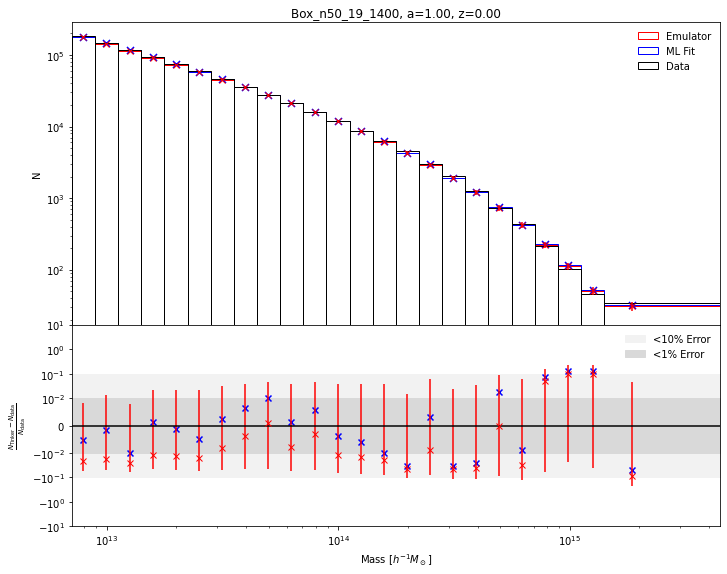

In [94]:
from multiprocessing import Pool

def estimate_uncertainty(param_combo):
    c_params = dict(zip(param_names, param_combo)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    return tinker_eval_MCMC

for a in reversed(N_data):
    if(a != 1):
        continue
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.2,0.4,.75,.6)), fig1.add_axes((0.2,0.0,.75,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    Pk = mass_function.Pka[a]
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])

    

    #get uncertainty in emulator prediction
    pool = Pool()
    uncertainty_estimate = list(tqdm(pool.imap(estimate_uncertainty, samples[box]), 
                                     total=len(samples[box])))    
    emulator_uncertainty = np.std(uncertainty_estimate, axis=0)


    #Emulator 
    c_params = dict(zip(param_names, mean[box])) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    
    axs[0].errorbar(Ms, tinker_eval_MCMC, emulator_uncertainty, fmt='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='red', label='Emulator')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, emulator_uncertainty/N, fmt='x', color='red')

    #ML Fit
    params = None
    if(box in box_test):
        params = Y_test[np.where(box_test==box)][0]
    elif(box in box_train):
        params = Y_train[np.where(box_train==box)][0]

    c_params = dict(zip(param_names, params)) | FIXED
    tinker_eval_MCMC = [mass_function.tinker(a, M_c, c_params,)*vol for M_c in M_numerics]
    f_dndM_MCMC =  interp1d(M_numerics, tinker_eval_MCMC, kind='linear', 
                            bounds_error=False, fill_value=0.)
    tinker_eval_MCMC = np.array([quad(f_dndM_MCMC, edge[0],  edge[1], epsabs=1e-1)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].scatter(Ms, (tinker_eval_MCMC-N)/N, marker='x', color='blue')

    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    axs[1].set_yscale('symlog', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm Tinker}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))
    i+=1

    axs[0].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_xlim((200*Mpart, np.max(edges)))
    axs[1].set_ylim((-1e1, 1e1))
    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/%s_deepgpemu_fit_%.2f.pdf'%(box, a), bbox_inches='tight')